<a href="https://colab.research.google.com/github/Himanshu069/trictrl/blob/sim/NMPC-Imitation/(DAgger)L2_NN_Controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""NN-controller with DAgger"""

!pip install torch pandas matplotlib
!pip install do-mpc
!pip install casadi

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import do_mpc
from casadi import *

# -------------------- Data Loading --------------------
df = pd.read_csv('nmpc_dataset[omega0andvarying].csv')
df = df.sort_values(['time']).reset_index(drop=True)
df['theta_next'] = df['theta'].shift(-1)
df['dtheta_next'] = df['dtheta'].shift(-1)
df['dphi_next'] = df['dphi'].shift(-1)
df['dt'] = df['time'].diff().shift(-1)
df = df.dropna()

X = df[['theta', 'dtheta', 'dphi']].values.astype(np.float32)
# X_next = df[['theta_next', 'dtheta_next', 'dphi_next']].values.astype(np.float32)
dt_array = df['dt'].values.astype(np.float32)
y = df['u'].values.reshape(-1, 1).astype(np.float32)

# indices = np.arange(len(X))
# train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42)
# val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

X_train, y_train = X, y
# X_val, y_val = X[val_idx], y[val_idx]
# X_test, y_test = X[test_idx], y[test_idx]

# mean = X_train.mean(axis=0)
# std = X_train.std(axis=0)
# std[std == 0] = 1e-8

# X_train = (X_train - mean) / std
# X_val = (X_val - mean) / std
# X_test = (X_test - mean) / std

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
# val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
# test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 64
initial_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:

# -------------------- Neural Network --------------------
class NMPCNet(nn.Module):
    def __init__(self, input_dim=3, hidden1=64, hidden2=64, output_dim=1):
        super(NMPCNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim),
        )

    def forward(self, x):
        return self.model(x)

model = NMPCNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def dynamics_derivative(state, u):
    """
    Computes the time derivative of the state
    state: [theta, dtheta, dphi]
    u: control torque
    Returns: [dtheta, ddtheta, ddphi]
    """
    theta, phi, dtheta, dphi = state

    # Equations of motion
    ddtheta = (M*g*np.sin(theta) - u) / I
    ddphi = u/Iw - ddtheta

    return np.array([dtheta, dphi, ddtheta, ddphi])

def dynamics_step(state, u, dt):
    """
    Simulates one step of the reaction wheel pendulum dynamics using RK4
    state: [theta, dtheta, dphi]
    u: control torque
    dt: time step
    Returns: next_state
    """
    # RK4 integration
    k1 = dynamics_derivative(state, u)
    k2 = dynamics_derivative(state + dt/2 * k1, u)
    k3 = dynamics_derivative(state + dt/2 * k2, u)
    k4 = dynamics_derivative(state + dt * k3, u)

    state_next = state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    state_next[0] = ((state_next[0] + np.pi) % (2*np.pi)) - np.pi

    return state_next

In [ ]:
# ----------------------------
# System parameters
# ----------------------------
M = 0.01825
mb = 0.286
mw = 0.079
Iw = 0.000040394
Ib = 0.0004370975
lb = 0.05
lw = 0.05
g = 9.81
I = Ib + mb*lb*lb + mw*lw*lw

# ----------------------------
# Model setup
# ----------------------------
model_type = 'continuous'
model1 = do_mpc.model.Model(model_type)

# States
t_abs = model1.set_variable(var_type='_tvp', var_name='t_abs')
theta = model1.set_variable('_x','theta')
phi = model1.set_variable('_x','phi')
dtheta = model1.set_variable('_x','dtheta')
dphi = model1.set_variable('_x','dphi')

# Control
u = model1.set_variable('_u','torque')

# Algebraic variables
ddtheta = model1.set_variable('_z', 'ddtheta')
ddphi = model1.set_variable('_z', 'ddphi')

# RHS
model1.set_rhs('theta', dtheta)
model1.set_rhs('phi', dphi)
model1.set_rhs('dtheta', ddtheta)
model1.set_rhs('dphi', ddphi)

# Euler-Lagrange equations
euler_lagrange = vertcat(
    (I+Iw)*ddtheta + Iw*ddphi - M*g*sin(theta),
    Iw*(ddtheta + ddphi) - u
)
model1.set_alg('euler_lagrange', euler_lagrange)
model1.setup()

# ----------------------------
# NMPC controller setup
# ----------------------------
mpc = do_mpc.controller.MPC(model1)
setup_mpc = {
    'n_horizon': 50,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.04,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 6,
    'collocation_ni': 1,
    'store_full_solution': True,
    'nlpsol_opts': {
        'ipopt.linear_solver': 'mumps',
        'ipopt.print_level': 0,
        'print_time': 0,
        'ipopt.sb': 'yes',
        'verbose': False
    }
}
mpc.set_param(**setup_mpc)

# Objective
Q1 = 1000
Q2 = 5
Q3 = 0.1
R = 1.0
omega_s = 0
omega_ref = 0 + 4.95 * sin(0.5 * model1.tvp['t_abs'])
mterm = Q1*model1.x['theta']**2 + Q2*model1.x['dtheta']**2 + Q3*(model1.x['dphi']-omega_s)**2
lterm = Q1*model1.x['theta']**2 + Q2*model1.x['dtheta']**2 + Q3*(model1.x['dphi']-omega_ref)**2
mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(torque=R)

# Control bounds
mpc.bounds['lower','_u','torque'] = -0.5
mpc.bounds['upper','_u','torque'] = 0.5

tvp_template_mpc = mpc.get_tvp_template()
t_step = 0.04
def tvp_fun(t_now):
        for k in range(50+1):
                tvp_template_mpc['_tvp',k,'t_abs'] = t_now + k*t_step

        return tvp_template_mpc

mpc.set_tvp_fun(tvp_fun)

mpc.setup()

# ----------------------------
# Estimator and simulator
# ----------------------------
estimator = do_mpc.estimator.StateFeedback(model1)
simulator = do_mpc.simulator.Simulator(model1)
sim_params = {'integration_tool': 'idas', 'abstol':1e-8, 'reltol':1e-8, 't_step':0.04}
simulator.set_param(**sim_params)
tvp_template_sim = simulator.get_tvp_template()
def tvp_fun_sim(t_now):
        tvp_template_sim['t_abs'] = t_now
        return tvp_template_sim
simulator.set_tvp_fun(tvp_fun_sim)
simulator.setup()

def expert_policy(state, t_now = 0.0):
    """
    Returns the first optimal NMPC input for the given state
    state: np.array or torch tensor of shape (4,)
    """
    if isinstance(state, torch.Tensor):
        state = state.detach().cpu().numpy().flatten()

    # Set initial state
    mpc.t0 = t_now
    mpc.x0 = state.reshape(-1,1)
    mpc.reset_history()
    mpc.set_initial_guess()
    simulator.x0 = state.reshape(-1,1)
    estimator.x0 = state.reshape(-1,1)

    # Solve NMPC and return first control input
    u_opt = mpc.make_step(state.reshape(-1,1))
    return float(u_opt[0,0])


In [ ]:

# -------------------- Training --------------------
def train_model(model, train_loader, val_loader, max_epochs=1000, patience=40, min_delta=1e-6):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []

    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            # print(f"Target u stats: mean={y_train.mean()}, std={y_train.std()}")
            # print(f"Target u range: [{y_train.min()}, {y_train.max()}]")
            # print(f"X_batch", X_batch)
            # print(f"y_batch", y_batch)
            optimizer.zero_grad()
            u_pred = model(X_batch)
            loss = criterion(u_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                u_pred = model(X_batch)
                loss = criterion(u_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'Epoch [{epoch+1}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'train_loss': train_loss
            }
            torch.save(checkpoint, 'best_model_checkpoint.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs.')
            break

    return train_losses, val_losses


In [ ]:
from torch.utils.data import random_split, DataLoader, TensorDataset
def rollout_policy(model, mean, std,env_dynamics, dt, rollout_steps=50, n_rollouts=20):
    """
    Runs the current NN policy for multiple rollouts from random initial theta values.
    Other states (dtheta, dphi) are initialized to zero.
    """
    model.eval()
    all_states = []
    all_timesteps=[]

    # Randomize theta only
    for _ in range(n_rollouts):
        theta0 = np.random.uniform(-np.pi, np.pi)
        thetadot0 = np.random.uniform(-10.0,10.0)
        state = np.array([theta0, 0.0, thetadot0, 0.0])
        t_current = 0.0

        for _ in range(rollout_steps):
            s_nn = np.array([state[0], state[2], state[3]])
            s_normalized = (s_nn - mean) / std
            s_tensor = torch.tensor(s_normalized, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                u = model(s_tensor).squeeze().item()
            next_state = dynamics_step(state, u, dt)
            all_states.append(next_state)
            all_timesteps.append(t_current)
            state = next_state
            t_current += dt

    return (torch.tensor(np.array(all_states), dtype=torch.float32),torch.tensor(np.array(all_timesteps), dtype=torch.float32))

all_train_losses, all_val_losses = [], []
dagger_iteration_metrics = []
def dagger_training(model, initial_loader, iterations=10, rollout_steps=50, dt=0.04):
    """
    Online DAgger: iteratively train policy, roll out, query expert, and aggregate dataset.
    """
    dataset_X, dataset_y = [], []

    # Initialize dataset with expert demonstrations
    for X_batch, y_batch in initial_loader:
        dataset_X.append(X_batch)
        dataset_y.append(y_batch)
    dataset_X = torch.cat(dataset_X)
    dataset_y = torch.cat(dataset_y)

    global mean, std
    X_np = dataset_X.numpy()
    mean = X_np.mean(axis=0)
    std = X_np.std(axis=0)
    std[std == 0] = 1e-8

    # Normalize initial dataset
    X_normalized = (X_np - mean) / std
    dataset_X = torch.from_numpy(X_normalized.astype(np.float32))
    for i in range(iterations):
        print(f"\n=== DAgger Iteration {i+1} ===")

        dataset = TensorDataset(dataset_X, dataset_y)
        val_size = int(0.2 * len(dataset))
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        dagger_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        # Train current model on aggregated dataset
        train_losses, val_losses = train_model(model, dagger_loader, val_loader)
        all_train_losses.extend(train_losses)
        all_val_losses.extend(val_losses)

        model.eval()
        with torch.no_grad():
            y_pred = []
            y_true = []
            for X_batch, y_batch in val_loader:
                y_hat = model(X_batch)
                y_pred.append(y_hat)
                y_true.append(y_batch)
            y_pred = torch.cat(y_pred).numpy()
            y_true = torch.cat(y_true).numpy()

        mse = np.mean((y_true - y_pred)**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_true - y_pred))
        r2 = 1 - ((y_true - y_pred)**2).sum() / ((y_true - y_true.mean())**2).sum()
        corr = np.corrcoef(y_true.flatten(), y_pred.flatten())[0,1]

        # Save metrics for this iteration
        dagger_iteration_metrics.append({
            'iteration': i+1,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Correlation': corr
        })

        print(f"Iteration {i+1} Metrics: MSE={mse:.6f}, RMSE={rmse:.6f}, MAE={mae:.6f}, R2={r2:.6f}, Corr={corr:.6f}")

        state_limits = [(-np.pi, np.pi), (-0.05, 0.05), (-50.0, 50.0), (-2000.0, 2000.0)]
        # Roll out current NN policy to gather new states
        new_states, new_times = rollout_policy(model, mean, std, dynamics_step, dt, rollout_steps=rollout_steps, n_rollouts=10)

        feasible_indices = []
        for rollout_start in range(0, len(new_states), rollout_steps):
          rollout_end = rollout_start + rollout_steps
          rollout_states = new_states[rollout_start:rollout_end]
          rollout_times = new_times[rollout_start:rollout_end]

          feasible_rollout = True
          for idx, s in enumerate(rollout_states):
            feasible_rollout = True
            s_full = np.array([s[0].item(), 0.0, s[1].item(), s[2].item()])
            for j, (low, high) in enumerate(state_limits):
              if s_full[j] < low or s_full[j] > high:
                  feasible_rollout = False
                  print("s_full", s_full)
                  break
            if not feasible_rollout:
                break
          if feasible_rollout:
              feasible_indices.extend(range(rollout_start, rollout_end))
        new_states = new_states[feasible_indices]
        new_times = new_times[feasible_indices]
        print("feasible states", len(new_states))

        new_states_np = new_states.numpy()
        new_states_np = np.clip(new_states_np, -1e3, 1e3)
        new_states_nn = new_states_np[:, [0,2,3]]
        new_states_normalized = (new_states_nn - mean) / std
        new_states = torch.from_numpy(new_states_normalized.astype(np.float32))
        # Query expert on visited states
        expert_labels = []
        for s, t in zip(new_states,new_times):
            s_full = np.array([s[0].item(), 0.0, s[1].item(), s[2].item()])
            t_val = t.item()
            u_expert = expert_policy(s_full, t_now=t_val)
            # print(f"s_full: {s_full}, t_val: {t_val}, u_expert: {u_expert}")
            expert_labels.append([u_expert])
        expert_labels = torch.tensor(expert_labels, dtype=torch.float32)

        # Aggregate data
        dataset_X = torch.cat([dataset_X, new_states])
        dataset_y = torch.cat([dataset_y, expert_labels])

        # X_np = dataset_X.numpy()
        # mean = X_np.mean(axis=0)
        # std = X_np.std(axis=0)
        # std[std == 0] = 1e-8

    return model



=== DAgger Iteration 1 ===
Epoch [1], Train Loss: 0.005158, Val Loss: 0.001738
Epoch [2], Train Loss: 0.001368, Val Loss: 0.001305
Epoch [3], Train Loss: 0.001120, Val Loss: 0.001158
Epoch [4], Train Loss: 0.000985, Val Loss: 0.001007
Epoch [5], Train Loss: 0.000856, Val Loss: 0.000903
Epoch [6], Train Loss: 0.000766, Val Loss: 0.000797
Epoch [7], Train Loss: 0.000673, Val Loss: 0.000705
Epoch [8], Train Loss: 0.000590, Val Loss: 0.000636
Epoch [9], Train Loss: 0.000535, Val Loss: 0.000564
Epoch [10], Train Loss: 0.000477, Val Loss: 0.000493
Epoch [11], Train Loss: 0.000420, Val Loss: 0.000447
Epoch [12], Train Loss: 0.000365, Val Loss: 0.000373
Epoch [13], Train Loss: 0.000327, Val Loss: 0.000323
Epoch [14], Train Loss: 0.000278, Val Loss: 0.000277
Epoch [15], Train Loss: 0.000239, Val Loss: 0.000249
Epoch [16], Train Loss: 0.000209, Val Loss: 0.000216
Epoch [17], Train Loss: 0.000178, Val Loss: 0.000179
Epoch [18], Train Loss: 0.000148, Val Loss: 0.000152
Epoch [19], Train Loss: 0.0

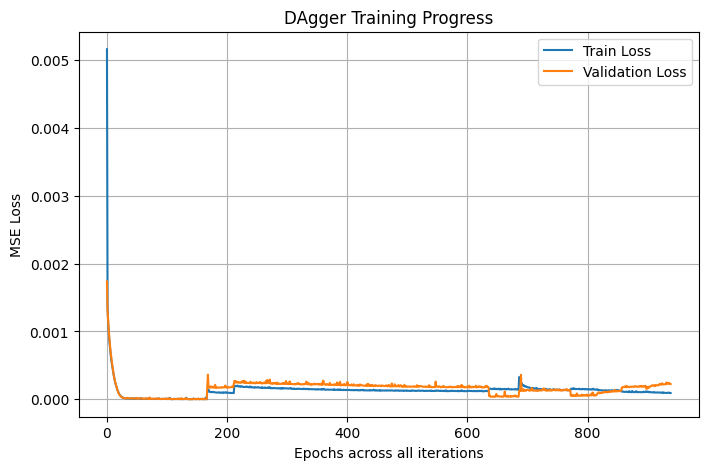

DAgger-trained model saved: nmpc_nn_dagger.pth
DAgger-trained model converted to NumPy file: nmpc_nn_dagger.npz
Iteration |        MSE |       RMSE |        MAE |         R2 |       Corr
----------------------------------------------------------------------
        1 | 0.000003 | 0.001685 | 0.000810 | 0.999778 | 0.999889
        2 | 0.000220 | 0.014831 | 0.004242 | 0.982670 | 0.991786
        3 | 0.000175 | 0.013210 | 0.002570 | 0.986860 | 0.993431
        4 | 0.000040 | 0.006335 | 0.002324 | 0.996737 | 0.998388
        5 | 0.000144 | 0.011993 | 0.004631 | 0.988917 | 0.994852
        6 | 0.000132 | 0.011483 | 0.002500 | 0.988774 | 0.994373
        7 | 0.000065 | 0.008045 | 0.003083 | 0.993594 | 0.997068
        8 | 0.000135 | 0.011607 | 0.002801 | 0.988487 | 0.994287
        9 | 0.000195 | 0.013961 | 0.003027 | 0.984576 | 0.992391
       10 | 0.000225 | 0.015000 | 0.003078 | 0.982786 | 0.991414


In [ ]:

# -------------------- Run DAgger --------------------
# model = NMPCNet()
dagger_model = dagger_training(model, initial_loader)
plt.figure(figsize=(8,5))
plt.plot(all_train_losses, label='Train Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epochs across all iterations')
plt.ylabel('MSE Loss')
plt.title('DAgger Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# -------------------- Save Final Model --------------------
torch.save(dagger_model.state_dict(), 'nmpc_nn_dagger.pth')
print("DAgger-trained model saved: nmpc_nn_dagger.pth")

weights = {name: param.detach().numpy() for name, param in dagger_model.named_parameters()}
weights['mean'] = mean
weights['std'] = std
np.savez("nmpc_nn_dagger.npz", **weights)
print("DAgger-trained model converted to NumPy file: nmpc_nn_dagger.npz")

print(f"{'Iteration':>9} | {'MSE':>10} | {'RMSE':>10} | {'MAE':>10} | {'R2':>10} | {'Corr':>10}")
print("-"*70)

# Print each iteration's metrics
for m in dagger_iteration_metrics:
    print(f"{m['iteration']:>9} | "
          f"{m['MSE']:.6f} | "
          f"{m['RMSE']:.6f} | "
          f"{m['MAE']:.6f} | "
          f"{m['R2']:.6f} | "
          f"{m['Correlation']:.6f}")